## From http://www.cnblogs.com/foley/p/5582358.html

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt

In [34]:
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

data = pd.read_csv('AirPassengers.csv', parse_dates=[0], index_col=0, date_parser=parse)
data.head()

,NumPassengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [37]:
ts = data['NumPassengers']

## 稳定性检验  
大数定理和中心定理中要求样本同分布（这里同分布等价于时间序列中的平稳性），而我们的建模过程中有很多都是建立在大数定理和中心极限定理的前提条件下的，如果它不满足，得到的许多结论都是不可靠的。以虚假回归为例，当响应变量和输入变量都平稳时，我们用t统计量检验标准化系数的显著性。而当响应变量和输入变量不平稳时，其标准化系数不在满足t分布，这时再用t检验来进行显著性分析，导致拒绝原假设的概率增加，即容易犯第一类错误  

宽平稳也叫弱平稳或者二阶平稳（均值和方差平稳），它应满足：

1.常数均值  2.常数方差  3.常数自协方差

In [44]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [46]:
rolmean = ts.rolling(window=12, center=False).mean()
rol_weighted_mean = ts.ewm(span=12, ignore_na=False,adjust=True,min_periods=0).mean()
rolstd  = ts.rolling(window=12, center=False).std()

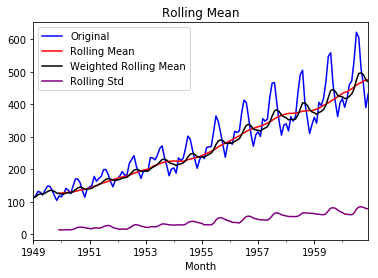

In [51]:
ts.plot(color='blue',label='Original')
rolmean.plot(color='red', label='Rolling Mean')
rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
rolstd.plot(color='purple', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show()

In [62]:
def testStationarity(ts):
    dftest = adfuller(ts)

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [63]:
testStationarity(ts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64

ADF是一种常用的单位根检验方法，他的原假设为序列具有单位根，即非平稳，对于一个平稳的时序数据，就需要在给定的置信水平上显著，拒绝原假设。ADF只是单位根检验的方法之一，如果想采用其他检验方法，可以安装第三方包arch，里面提供了更加全面的单位根检验方法。检验结果其p值大于0.99，说明并不能拒绝原假设

In [60]:
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

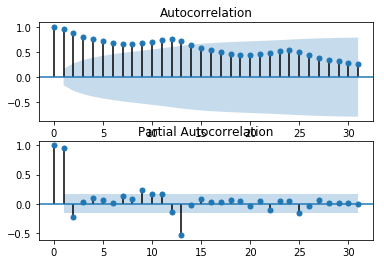

In [61]:
#具有年周期成分和长期趋势成分。平稳序列的自相关系数会快速衰减，下面的自相关图并不能体现出该特征，所以我们有理由相信该序列是不平稳的。
draw_acf_pacf(ts)

## 平稳性处理

### 对数变换  
对数变换主要是为了减小数据的振动幅度，使其线性规律更加明显。对数变换相当于增加了一个惩罚机制，数据越大其惩罚越大，数据越小惩罚越小。

In [65]:
ts_log = np.log(ts)
testStationarity(ts_log)

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64

### 平滑法

窗口为12的移动平均能较好的剔除年周期性因素，而指数平均法是对周期内的数据进行了加权，能在一定程度上减小年周期因素，但并不能完全剔除，如要完全剔除可以进一步进行差分操作。

### 差分法

经过12阶差分和1阶差分后，该序列满足平稳性的要求了。

In [68]:
diff_12 = ts_log.diff(12)
diff_12.dropna(inplace=True)
diff_12_1 = diff_12.diff(1)
diff_12_1.dropna(inplace=True)
testStationarity(diff_12_1)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (5%)             -2.886363
Critical Value (1%)             -3.487022
Critical Value (10%)            -2.580009
dtype: float64